# 1D parameter scan for cell signalling pathway 
nicole pagane
3/07/18

### import necessary modules

In [1]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as snt
from scipy.optimize import curve_fit
from numpy.linalg import svd
import os
import plotly.plotly as py
import plotly.graph_objs as go
from decimal import Decimal
from matplotlib.colors import LogNorm

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [2]:
### plot kp by kpp with different differentials to represent the density

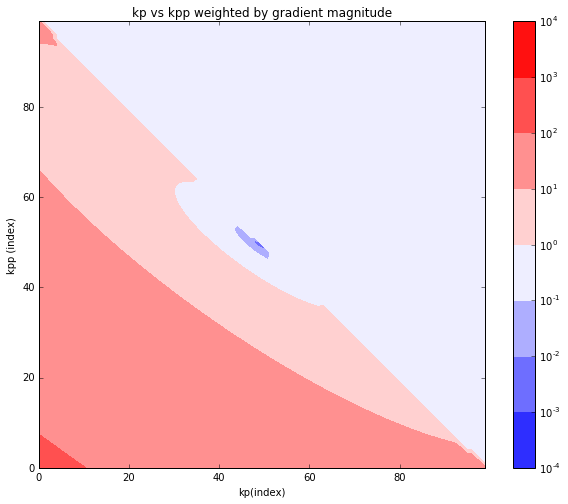

In [59]:
## SPECIES ###
# S    substrate                        (c1)
# K    kinase                           (c2)
# Kp   phosphorylated kinase            (c3)
# Kpp  doubly phosphorlyated kinase     (c4)

### EQUATIONS FOR CELL SIGNALLING ###
# S + K -> S + Kp  (k1)
#     K -> Kp      (k2)
#    Kp -> K       (k3)
#    Kp -> Kpp     (k4)
#   Kpp -> Kp      (k5)

fig = plt.figure(figsize=(10,8))

conc2 = 20
conc1 = 10

# kinetic rate constants
k1 = 1e-2
k2 = 5e-3
k3 = 1e-3
k4 = 5e-2
k5 = 5e-2

#k1 = 0.16029789
#k2 = 0.02496614
#k3 = 0.98651079
#k4 = 0.0152954
#k5 = 0.01561406

#equilibrium concentrations
S = 15
Ktot = 50

Kp = np.linspace(0,50,100)
Kpp = np.linspace(0,50,100)

#append to differential space
A = np.matrix(np.asarray([
                -k1, -k2, k3, 0,
                k1, k2, -k3-k4, k5, 
                0, 0, k4, -k5 ]).reshape([3,4]))

grad = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])
for i in range(len(Kp)):
    for j in range(len(Kpp)):
        K = Ktot - Kp[i] - Kpp[j]
        if K >= 0:
            grad[i,j] = np.sum(np.power(A*np.asarray([S*K,K,Kp[i],Kpp[j]]).reshape([4,1]),2))


plt.contourf(grad, cmap = 'bwr', norm = LogNorm())
plt.xlabel('kp(index)')
plt.ylabel('kpp (index)')
plt.title('kp vs kpp weighted by gradient magnitude')
plt.colorbar()

plt.show()

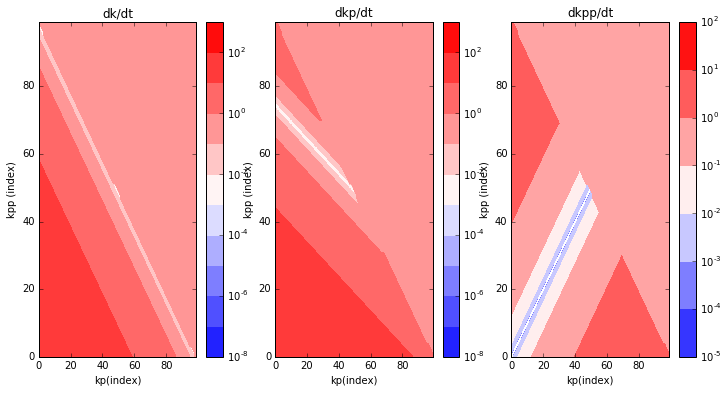

In [60]:
#find individual kinase differentials
dk = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])
dkp = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])
dkpp = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])
for i in range(len(Kp)):
    for j in range(len(Kpp)):
        K = Ktot - Kp[i] - Kpp[j]
        if K >= 0:
            dk[i,j] = np.power(A*np.asarray([S*K,K,Kp[i],Kpp[j]]).reshape([4,1]),2)[0]
            dkp[i,j] = np.power(A*np.asarray([S*K,K,Kp[i],Kpp[j]]).reshape([4,1]),2)[1]
            dkpp[i,j] = np.power(A*np.asarray([S*K,K,Kp[i],Kpp[j]]).reshape([4,1]),2)[2]

#plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,3,1)
plt.contourf(dk, cmap = 'bwr', norm = LogNorm())
plt.xlabel('kp(index)')
plt.ylabel('kpp (index)')
plt.title('dk/dt')
plt.colorbar()
ax = fig.add_subplot(1,3,2)
plt.contourf(dkp, cmap = 'bwr', norm = LogNorm())
plt.xlabel('kp(index)')
plt.ylabel('kpp (index)')
plt.title('dkp/dt')
plt.colorbar()
ax = fig.add_subplot(1,3,3)
plt.contourf(dkpp, cmap = 'bwr', norm = LogNorm())
plt.xlabel('kp(index)')
plt.ylabel('kpp (index)')
plt.title('dkpp/dt')
plt.colorbar()

plt.show()

In [61]:
trace = go.Heatmap(z = np.log(grad.tolist()))
data=[trace]
py.iplot(data, filename='basic-heatmap')


In [62]:
#nullspace function courtesy of scipy
def nullspace(A, atol=1e-13, rtol=0):
    """Compute an approximate basis for the nullspace of A.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length k will be treated
        as a 2-D with shape (1, k)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    ns : ndarray
        If `A` is an array with shape (m, k), then `ns` will be an array
        with shape (k, n), where n is the estimated dimension of the
        nullspace of `A`.  The columns of `ns` are a basis for the
        nullspace; each element in numpy.dot(A, ns) will be approximately
        zero.
    """

    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

### plot dkpp/dt for the numerical solutions of the kinetic laws to determine best fit parameters

In [66]:
tol = 0.5
cols = sum(grad < tol) 
mins = []
inds = []
for i in range(len(cols)):
    if cols[i] > 0:
        for j in range(len(grad[i,:])):
            if grad[i,j] < tol:
                mins.append(grad[i,j])
                inds.append([i,j])
                
mins = np.asarray(mins)
print len(inds)

112


In [67]:
def nullparam(S,K,kp, kpp):
    mat = np.matrix([
            [-k1*S*K, -k2*K, kp*k3, 0, 0], 
            [k1*S*K, k2*K, -k3*kp, -k4*kp, k5*kpp], 
            [0, 0, 0, k4*kp, -k5*kpp]
              ])
    nullmat = nullspace(mat)
    for i in range(3):
        if len(nullmat) == sum(nullmat[:,i] > 0):
            return nullmat[:,i]
    return np.zeros(len(nullmat))

T = 10
def rates(y, t, k1, k2, k3, k4, k5):
    return np.asarray([float(conc2 + conc1)/(2*T), 
                       -k1*y[0]*y[1] - k2*y[1] + k3*y[2],
                       k1*y[0]*y[1] + k2*y[1] - k3*y[2] - k4*y[2] + k5*y[3],
                       k4*y[2] -  k5*y[3]])

odeTrials = {}
acc = []
ind = 0
n = 100
t = np.linspace(0,T,n)
for i in range(len(inds)):
    params = nullparam(15, Ktot - Kp[inds[i][0]] - Kpp[inds[i][1]], Kp[inds[i][0]], Kpp[inds[i][1]])
    y0 = [0, 40,5,5]
    if sum(params > 0):
        ode = snt.odeint(rates, y0,t, args = tuple(params))
        odeTrials[ind] = []
        odeTrials[ind] = ode
        acc.append(params)
        ind = ind+ 1

print ind

38


In [78]:
#create traces
data = []
for i in odeTrials.keys():
    trace = go.Scatter(
    y = odeTrials[i][:,1][0:n-1],
    x = t,
    mode = 'lines',
    #name = ''.join([str('%.2E' % Decimal(params['k3'][i])), ", ", str('%.2E' % Decimal(params['k4'][i],2)), 
     #  ", ", str('%.2E' % Decimal(params['k5'][i],2))])
    )
    data.append(trace)

py.iplot(data, filename='scatter-mode')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~peptime/0 or inside your plot.ly account where it is named 'scatter-mode'


In [68]:
#create traces
data = []
for i in odeTrials.keys():
    dkpp = np.diff(odeTrials[i][:,3])/np.diff(t)
    trace = go.Scatter(
    x = odeTrials[i][:,3][0:n-1],
    y = dkpp,
    mode = 'lines',
    #name = ''.join([str('%.2E' % Decimal(params['k3'][i])), ", ", str('%.2E' % Decimal(params['k4'][i],2)), 
     #              ", ", str('%.2E' % Decimal(params['k5'][i],2))])
    )
    data.append(trace)

py.iplot(data, filename='scatter-mode')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~peptime/0 or inside your plot.ly account where it is named 'scatter-mode'


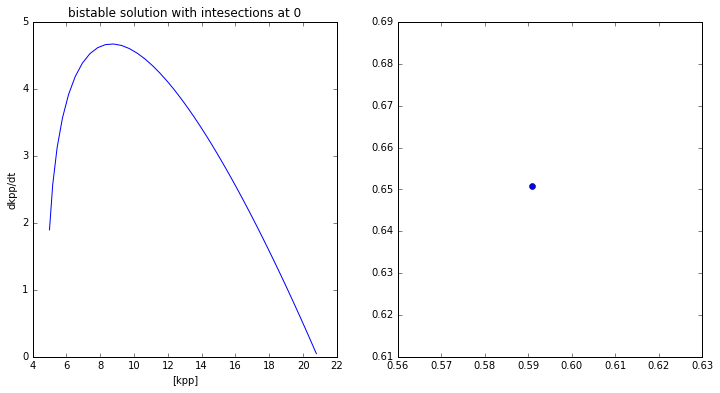

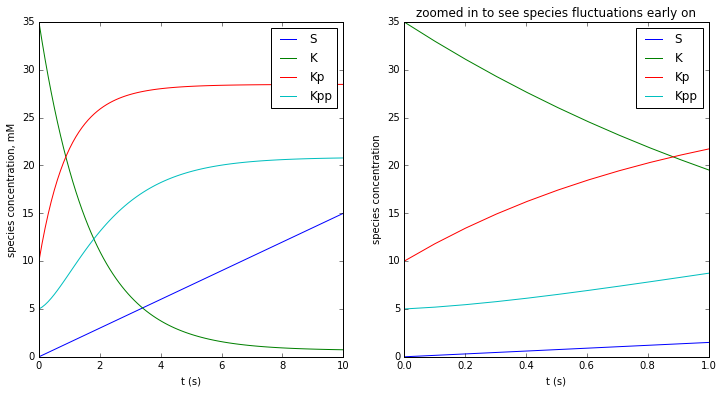

In [199]:
## SPECIES ###
# S    substrate                        (c1)
# K    kinase                           (c2)
# Kp   phosphorylated kinase            (c3)
# Kpp  doubly phosphorlyated kinase     (c4)

### EQUATIONS FOR CELL SIGNALLING ###
# S + K -> S + Kp  (k1)
#     K -> Kp      (k2)
#    Kp -> K       (k3)
#    Kp -> Kpp     (k4)
#   Kpp -> Kp      (k5)

# define rates equations
conc2 = 20
conc1 = 10
T = 10
def rates(y, t, k1, k2, k3, k4, k5):
    return np.asarray([float(conc2 + conc1)/(2*T), 
                       -k1*y[0]*y[1] - k2*y[1] + k3*y[2],
                       k1*y[0]*y[1] + k2*y[1] - k3*y[2] - k4*y[2] + k5*y[3],
                       k4*y[2] -  k5*y[3]])

# plot species
k1 = 0.00271278
k2 = 0.59083339
k3 = 0.01450234
k4 = 0.47664103
k5 = 0.65077765

#initial concentrations
c1 = 0
c2 = 35
c3 = 10
c4 = 5
V =1
y0 = np.asarray([c1, c2, c3, c4])/V #initial species concentration

n = 100
t = np.linspace(0,T,n)
ode = snt.odeint(rates, y0,t, args = (k1, k2, k3, k4, k5))

#find dkpp/dt
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
dkpp = np.diff(ode[:,3])/np.diff(t)
ax.plot(ode[:,3][0:n-1],dkpp)
ax.set_title('bistable solution with intesections at 0')
ax.set_xlabel('[kpp]')
ax.set_ylabel('dkpp/dt')

#plot two parameters against each other to determine bistable solution
ax = fig.add_subplot(1,2,2)
ax.plot(k2, k5, 'o')


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['S', 'K', 'Kp', 'Kpp'])

#zoom in 
ax = fig.add_subplot(1,2,2)
t = np.linspace(0, T, n)
ode = snt.odeint(rates, y0,t, args = (k1, k2, k3, k4, k5))
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
ax.set_title('zoomed in to see species fluctuations early on')
ax.set_ylabel('species concentration')
ax.legend(['S', 'K', 'Kp', 'Kpp'])
ax.set_xlim([0,1])


plt.show()